# Fixing the training data corruption on the previous ml models
2025-01-24

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn.tree
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc

In [2]:
AF_prediction_path = Path("../ressources/AF_predictions").resolve()
AF_prediction_results = Path("../ressources/AF_predictions/AF_prediction_randomized_DMI_results.xlsx").resolve()
AF_prediction_metrics = Path("../ressources/AF_predictions/AF_metrics_all_structures.tsv").resolve()
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
AF_DDI_structures_path = Path("../ressources/AF_DDI_structures").resolve()
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()
solved_DDI_structures_path = Path("../ressources/DDI_solved_structures_hydrogens").resolve()

for p in [AF_prediction_results, AF_prediction_metrics, AF_DDI_structures_path, solved_DMI_structures_path, solved_DDI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [3]:
import hashlib

def md5hash(s: str): 
    return hashlib.md5((s+"1234").encode('utf-8')).hexdigest()

dataAF = pd.read_csv(AF_prediction_path / "data_af.csv")
dataAF.index = dataAF["prediction_name"] + "_" + dataAF["model_id"]
dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)
dataAF["structure_name_hash"] = dataAF["structure_name"].apply(md5hash)
print(dataAF.columns)
dataAF

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'structure_name_hash'],
      dtype='object')


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_1.pdb,9,0,580.310,6.083,0,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_2.pdb,10,0,662.104,6.072,3,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_3.pdb,2,0,398.498,5.417,0,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_4.pdb,2,0,323.304,5.092,9,2d6af753d6000a202be8341e2e0b6d86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_0,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_0,0.298701,49.827778,73.161904,62.392307,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0.pdb,7,3,1617.382,5.591,56,6823ec2877f0851aaa28c3ef29db2ca0
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_1,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_1,0.246961,54.362000,76.415000,66.390909,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1.pdb,3,0,791.256,6.373,7,6823ec2877f0851aaa28c3ef29db2ca0
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_2,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_2,0.211579,52.651538,72.910908,61.937083,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2.pdb,2,1,882.547,7.906,11,6823ec2877f0851aaa28c3ef29db2ca0
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_3,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_3,0.211144,50.398334,78.798751,66.627144,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3.pdb,7,5,1020.896,4.628,44,6823ec2877f0851aaa28c3ef29db2ca0


In [4]:
X_columns = ["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]
dataAF_randomDMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "random minimal")]
dataAF_mutated1DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "1")]
dataAF_mutated2DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "2")]
dataAF_randomDDI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "approved minimal DDI", dataAF["num_mutation_in_motif"] == "random minimal DDI")]

dataAF_randomDMI = dataAF_randomDMI.sort_values(by=["structure_name_hash", "model_id"])
dataAF_mutated1DMI = dataAF_mutated1DMI.sort_values(by=["structure_name_hash", "model_id"])
dataAF_mutated2DMI = dataAF_mutated2DMI.sort_values(by=["structure_name_hash", "model_id"])
dataAF_randomDDI = dataAF_randomDDI.sort_values(by=["structure_name_hash", "model_id"])

print(dataAF_randomDMI.shape, dataAF_mutated1DMI.shape, dataAF_mutated2DMI.shape, dataAF_randomDDI.shape)


randomDMI_xy = train_test_split(dataAF_randomDMI[X_columns], dataAF_randomDMI["label"], test_size=0.2, random_state=2501, shuffle=False)
mutated1DMI_xy = train_test_split(dataAF_mutated1DMI[X_columns], dataAF_mutated1DMI["label"], test_size=0.2, random_state=2501, shuffle=False)
mutated2DMI_xy = train_test_split(dataAF_mutated2DMI[X_columns], dataAF_mutated2DMI["label"], test_size=0.2, random_state=2501, shuffle=False)
randomDDI_xy = train_test_split(dataAF_randomDDI[X_columns], dataAF_randomDDI["label"], test_size=0.2, random_state=2501, shuffle=False)

print("Random DMI: Train", randomDMI_xy[0].shape, "Test", randomDMI_xy[1].shape)
print("1 Mutation DMI: Train", mutated1DMI_xy[0].shape, "Test", mutated1DMI_xy[1].shape)
print("2 Mutation DMI: Train", mutated2DMI_xy[0].shape, "Test", mutated2DMI_xy[1].shape)
print("Random DDI: Train", randomDDI_xy[0].shape, "Test", randomDDI_xy[1].shape)


(1332, 37) (1332, 37) (1332, 37) (453, 37)
Random DMI: Train (1065, 17) Test (267, 17)
1 Mutation DMI: Train (1065, 17) Test (267, 17)
2 Mutation DMI: Train (1065, 17) Test (267, 17)
Random DDI: Train (362, 17) Test (91, 17)


In [83]:
X_columns

['model_confidence',
 'chainA_intf_avg_plddt',
 'chainB_intf_avg_plddt',
 'intf_avg_plddt',
 'pDockQ',
 'iPAE',
 'buried_area',
 'min_distance',
 'hbonds',
 'salt_bridges',
 'hydrophobic_interactions',
 'num_chainA_intf_res',
 'num_chainB_intf_res',
 'num_res_res_contact',
 'num_atom_atom_contact',
 'chainA_length',
 'chainB_length']

In [5]:
def Fit(name, data, params, columns=None, plot=False):
    x_train, x_test, y_train, y_test = data
    if columns is not None:
        x_train, x_test = x_train[columns], x_test[columns]

    rf = RandomForestClassifier(random_state=2501, n_estimators=200)
    rs = RandomizedSearchCV(n_iter=10, estimator=rf, param_distributions=params, scoring="accuracy", n_jobs=-1, verbose=2, random_state=2501)
    rs.fit(x_train, y_train)
    rf_best = rs.best_estimator_
    y_predict = rf_best.predict(x_test)
    y_prob = rf_best.predict_proba(x_test)

    score = accuracy_score(y_test, y_predict)
    roc_score = roc_auc_score(y_test, y_prob[:,1])
    roc_score_confidence = roc_auc_score(y_test, x_test["model_confidence"])
    roc_curvexy = roc_curve(y_test, y_prob[:,1])
    roc_curvexy_confidence = roc_curve(y_test, x_test["model_confidence"])

    print("Score:", score)
    print("ROC_AUC_score:", roc_score)
    display(rf_best)

    _line2D = plt.plot(roc_curvexy[0], roc_curvexy[1], label=f"{name} ml prediction (AUC = {roc_score:.2f})")[0]
    c = np.array(colors.to_rgb(_line2D.get_color()))
    c1 = np.clip(1.2*c, a_max=1, a_min=None)
    c2 = 0.7*c
    _line2D.set_color(c1)
    plt.plot(roc_curvexy_confidence[0], roc_curvexy_confidence[1], label=f"{name} model confidence (AUC = {roc_score_confidence:.2f})", color=c2)
    
    if plot:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Model and Test Subset Features")
        plt.legend(loc="lower right")
        plt.show()
    return rf_best

Score: 0.797752808988764
ROC_AUC_score: 0.8888265019651882


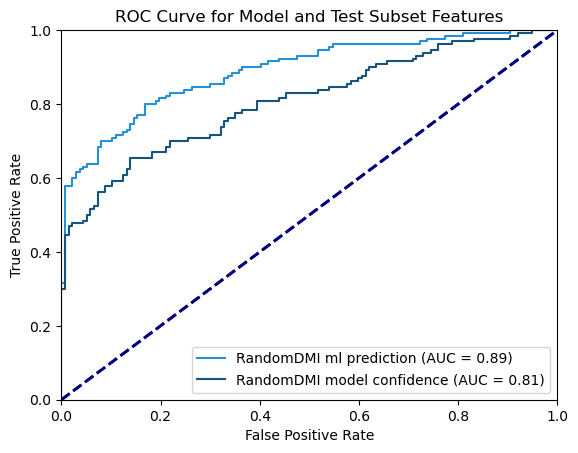

Score: 0.7142857142857143
ROC_AUC_score: 0.8723404255319148


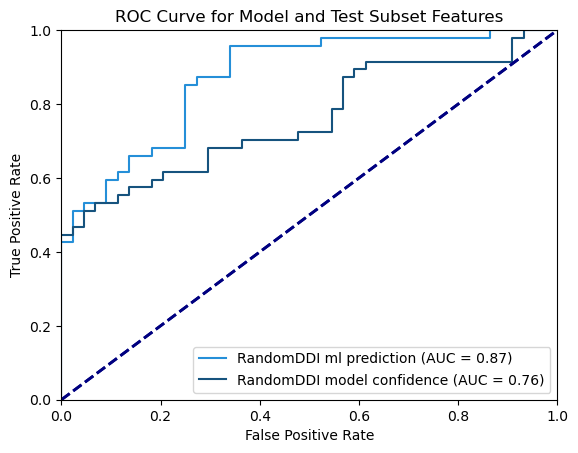

In [21]:
Fit("RandomDMI", randomDMI_xy)
Fit("RandomDDI", randomDDI_xy)

In [9]:
randomDDI_xy[1]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
D1PF08644_PF03531_4KHB.D2PF09809_PF06984_5OOL_ranked_4,0.177046,46.489166,54.440001,50.002326,0.036055,20.665550,1767.538,5.174,8,2,192,24,19,53,621,82,86
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_0,0.692902,89.367894,88.376000,88.930294,0.192467,2.873899,1345.952,4.643,5,5,25,19,15,40,269,81,48
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_1,0.569047,83.287778,82.211429,82.816875,0.127697,4.397363,1190.304,4.655,6,8,15,18,14,36,265,81,48
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_2,0.280830,84.277143,73.468751,78.512667,0.045730,10.934839,669.216,5.935,4,4,3,7,8,16,166,81,48
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_3,0.270853,90.825001,79.733001,83.892501,0.057758,15.862081,698.903,4.868,5,6,11,6,10,17,182,81,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF12348_PF00091_6MZF_Y_RESI3_RESI212.Z_RESI309_RESI529_ranked_0,0.259115,74.421429,74.657500,74.547334,0.034547,22.608681,670.434,5.576,3,3,0,7,8,13,132,208,221
PF12348_PF00091_6MZF_Y_RESI3_RESI212.Z_RESI309_RESI529_ranked_1,0.257412,75.827499,69.283333,73.022857,0.019627,26.119560,237.914,7.625,0,0,0,4,3,5,9,208,221
PF12348_PF00091_6MZF_Y_RESI3_RESI212.Z_RESI309_RESI529_ranked_2,0.246138,82.207499,75.348333,78.091999,0.022187,27.392124,330.234,7.647,0,0,0,4,6,6,30,208,221
PF12348_PF00091_6MZF_Y_RESI3_RESI212.Z_RESI309_RESI529_ranked_3,0.228620,83.770000,80.154999,81.962500,0.020949,23.721836,254.485,7.579,1,1,0,4,4,5,24,208,221


c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Score: 0.7677902621722846
ROC_AUC_score: 0.836006979624001


RandomForestClassifier(max_features=5, min_impurity_decrease=0.03,
                       n_estimators=200, random_state=2501)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Score: 0.5274725274725275
ROC_AUC_score: 0.7236686390532545


RandomForestClassifier(max_features=4, min_impurity_decrease=0.03,
                       n_estimators=200, random_state=2501)

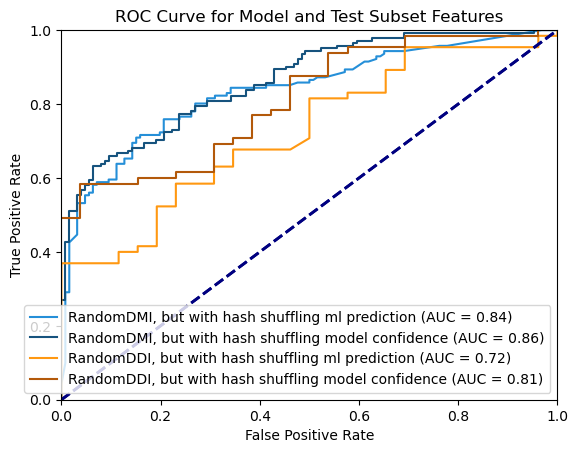

In [6]:
params = {
    "min_impurity_decrease" : [0.03],
    "max_features": [4,5,6,7,8]
}
rf_randomDMI = Fit("RandomDMI, but with hash shuffling", randomDMI_xy, params)
rf_randomDDI = Fit("RandomDDI, but with hash shuffling", randomDDI_xy, params, plot=True)

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Score: 0.7602996254681648
ROC_AUC_score: 0.8369920072047732


RandomForestClassifier(min_impurity_decrease=0.03, n_estimators=200,
                       random_state=2501)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Score: 0.5274725274725275
ROC_AUC_score: 0.7236686390532545


RandomForestClassifier(min_impurity_decrease=0.03, n_estimators=200,
                       random_state=2501)

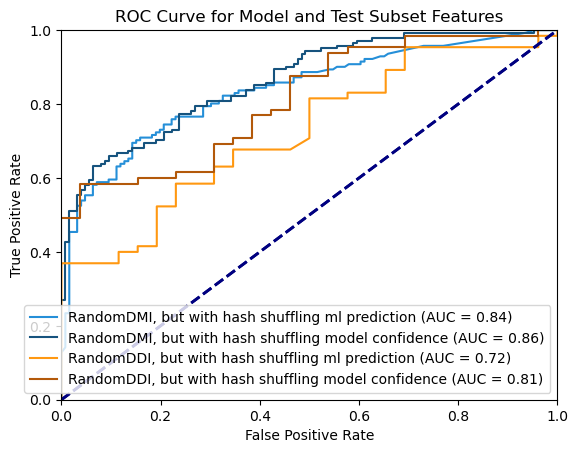

In [108]:
params = {
    "min_impurity_decrease" : [0.03],
}
rf_randomDMI = Fit("RandomDMI, but with hash shuffling", randomDMI_xy, params)
rf_randomDDI = Fit("RandomDDI, but with hash shuffling", randomDDI_xy, params, plot=True)

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Score: 0.7677902621722846
ROC_AUC_score: 0.8618147022402342


RandomForestClassifier(max_depth=2, min_impurity_decrease=0, n_estimators=200,
                       random_state=2501)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Score: 0.5274725274725275
ROC_AUC_score: 0.7227810650887575


RandomForestClassifier(max_depth=2, min_impurity_decrease=0, n_estimators=200,
                       random_state=2501)

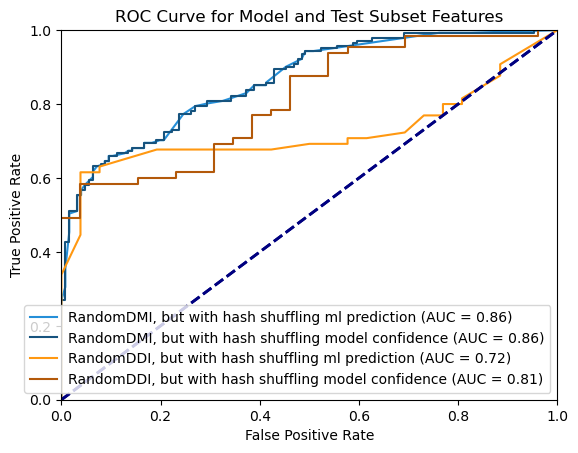

In [110]:
params = {
    "min_impurity_decrease" : [0],
    "max_depth": [2]
}
rf_randomDMI = Fit("RandomDMI, but with hash shuffling", randomDMI_xy, params, columns=["model_confidence"])
rf_randomDDI = Fit("RandomDDI, but with hash shuffling", randomDDI_xy, params, columns=["model_confidence"], plot=True)

In [102]:
rf_randomDDI.predict_proba(randomDDI_xy[1][["model_confidence"]])

array([[0.70183445, 0.29816555],
       [0.20893929, 0.79106071],
       [0.29770121, 0.70229879],
       [0.72714323, 0.27285677],
       [0.72360504, 0.27639496],
       [0.71484615, 0.28515385],
       [0.70108584, 0.29891416],
       [0.70183445, 0.29816555],
       [0.70183445, 0.29816555],
       [0.70183445, 0.29816555],
       [0.70243966, 0.29756034],
       [0.69799803, 0.30200197],
       [0.70108584, 0.29891416],
       [0.70183445, 0.29816555],
       [0.70183445, 0.29816555],
       [0.70243966, 0.29756034],
       [0.68416413, 0.31583587],
       [0.67962212, 0.32037788],
       [0.67962212, 0.32037788],
       [0.67692976, 0.32307024],
       [0.67666878, 0.32333122],
       [0.00244629, 0.99755371],
       [0.00244629, 0.99755371],
       [0.00244629, 0.99755371],
       [0.00244629, 0.99755371],
       [0.02367985, 0.97632015],
       [0.72808797, 0.27191203],
       [0.72808797, 0.27191203],
       [0.72082764, 0.27917236],
       [0.71484615, 0.28515385],
       [0.

In [117]:
x = list(set(rf_randomDDI.predict_proba(randomDDI_xy[1][["model_confidence"]])[:,1]))
x.sort()
for i in range(len(x)-1):
    print(x[i+1]-x[i])

0.0009447487113402597
0.0035381841574206874
0.0006489361702127217
0.0008813020116092418
0.000887492143306079
0.00035967383707918854
0.0007121916063458911
0.005269294109614853
0.0019366893223233261
8.161130058415011e-06
0.0056522159546615325
0.0009891935815955488
0.003820233116598848
0.0006052036199095112
0.0007486104270738592
0.0030503404143796264
3.74722158669738e-05
0.004718355090986559
0.0007731743042477812
0.008342374308732081
0.004542004390930998
0.002692362089269651
0.00026097856336576575
0.37896757354895166
0.0887619180890643
0.008737034527200094
0.001052631578947416
0.049936523832407875
0.12553325574339724
0.0008974358974358498
0.011247472630738553
0.007713649156107727
0.001374999999999904


## Manual data correlation inspection

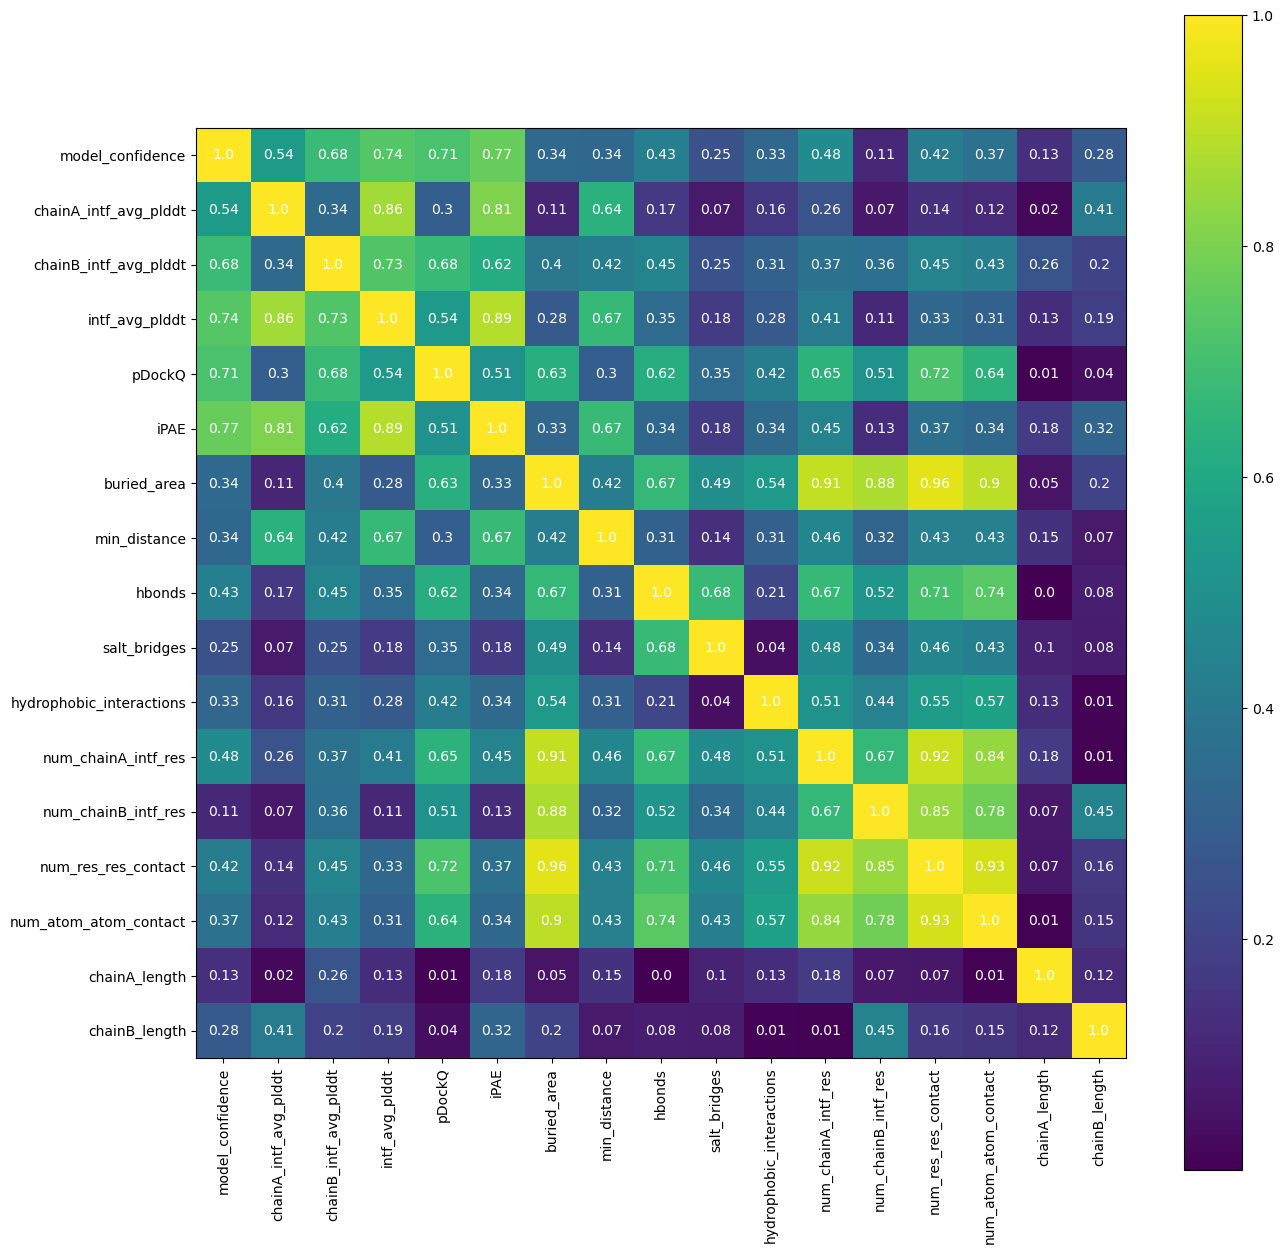

In [125]:
correlations = np.corrcoef([dataAF[c] for c in X_columns])
correlations = np.abs(correlations)
plt.figure(figsize=(15,15))
ims = plt.imshow(correlations)
plt.colorbar(ims)
plt.xticks(range(len(X_columns)), labels=X_columns, rotation=90)
plt.yticks(range(len(X_columns)), labels=X_columns)
for i in range(len(X_columns)):
    for j in range(len(X_columns)):
        text = plt.text(j, i, round(correlations[i, j],2), ha="center", va="center", color="w")
plt.show()

In [ ]:
correlations = np.corrcoef([dataAF[c] for c in X_columns], randomDMI_xy)
correlations = np.abs(correlations)